In [1]:
import numpy as np
import torch
import torch.distributions.constraints as constraints
import torch.distributions as tdist
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
from pyro.infer.autoguide import AutoNormal
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle as pkl

pyro.set_rng_seed(101)
pyro.__version__


'1.8.4+9ed468d'

## Load data

You need to reshape & load your data into tensor with different dimensions, see Pyro documentation for more info.
You can load data and see the tensor shapes.

import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import anndata as ad
adata = ad.read_h5ad("/PHShome/jr1025/projects/ANBE/data/07+1021_ANBE_data/crisprep_count/crisprep_count_07+1021_LDLvar.h5ad")

import load_data
adata = load_data.standardize_guide_per_target_counts(adata)

adata

item_count = 0
prev_item = ""
for item in adata.obs.target.to_list():
    if item_count == 0:
        item_count += 1
        prev_item = item
    else:
        if item == prev_item:
            item_count += 1
        else:
            assert item_count == 5, "not all targets are consecutive in len 5"
            item_count = 1
            prev_item = item

tdata = load_data.get_data(adata)

target_info = adata.obs[["target", "Group"]].drop_duplicates()
target_info = target_info[target_info.Group != 0.0]
target_info

tdata.fitted_dispersion

In [2]:
tdata = pkl.load(open("data_dict_share.pkl", "rb"))


def get_size_factor(X):
    """Get size factor for samples."""
    n_guides, n_samples = X.shape
    geom_mean_x = np.exp((1 / n_samples) * np.log(X + 0.5).sum(axis=1))
    assert geom_mean_x.shape == (n_guides,)
    norm_count = X / geom_mean_x[:, None]
    size_factor = np.median(norm_count, axis=0)
    assert size_factor.shape == (n_samples,)
    return torch.from_numpy(size_factor)


print(tdata.keys())
print(tdata["X"].shape)
tdata["size_factor"] = get_size_factor(tdata["X"].transpose(1, 2).flatten(1, 2).T)
tdata["condition"] = tdata.pop("conditon")


dict_keys(['depth', 'n_samples', 'n_sgRNAs_per_target', 'n_targets', 'X', 'X_bcmatch', 'edits', 'depth_bcmatch', 'edit_rate', 'conditon', 'fitted_dispersion'])
torch.Size([8, 5, 694])


In [43]:
tdata["n_sgRNAs_per_target"]


5

### Our model:

Basic model:

Information in data
* For each sgRNA, 
  * fitted dispersion_trend_{i}

data has 4 attributes:  
* sgRNA: torch.Size(n_sgRNA)  
* sample: torch.Size(n_sample) # 2 in top vs bot case
* X: torch.Size(n_sgRNA, n_sample)
* X_bcmatch: torch.Size(n_sgRNA, n_sample)
* edits: torch.Size(n_sgRNA, n_sample)

In [6]:
tdata["X_bcmatch"].shape


torch.Size([8, 5, 694])

In [8]:
tdata["edit_rate"].shape


torch.Size([5, 694])

Guide should include  
* All unobserved variables: beta_1, beta_0, dispersion, pi, K_0

### Load model & guide

In [12]:
# from mageck_model import *


In [48]:
tdata["X"].transpose(1, 2).shape


torch.Size([8, 694, 5])

In [55]:
tdata["size_factor"]


array([0.47809333, 1.1139171 , 0.66519105, 0.9280685 , 1.6125845 ,
       1.1015966 , 1.9024975 , 0.9915545 ], dtype=float32)

### Simpler model

This model has  
* K_1 sampled and conditioned to data.X
* pi is assumed to be 1


In [9]:
# mu and sigma params
# sample beta_j from normal(mu, sigma)


def model_mageck3(data, alpha_init=1):
    # Binomial mixed model with Bernoulli sampled edits with fitted pi
    n_targets = data["n_targets"]
    n_sgRNAs_per_target = data["n_sgRNAs_per_target"]
    n_reps = len(data["depth"]) // 2
    dispersion_var = 1

    with pyro.plate("target_plate", n_targets):
        beta_1 = pyro.sample("beta_1", dist.Laplace(0.0, 0.1))
        beta_0 = pyro.sample("beta_0", dist.Normal(0, 1))

        assert beta_1.shape == (n_targets,)
        assert beta_0.shape == (n_targets,)

        with pyro.plate("sgRNA_plate", n_sgRNAs_per_target):
            # Sample dimension == (n_sgRNAs_per_target, n_targets,)

            dispersion = pyro.sample(
                "dispersion",
                dist.LogNormal(data["fitted_dispersion"].log(), dispersion_var),
            )
            assert dispersion.shape == (
                n_sgRNAs_per_target,
                n_targets,
            )

            # pi_alpha_0 = torch.ones_like(data["edit_rate"], requires_grad=True)
            # pi_beta_0 = torch.ones_like(data["edit_rate"], requires_grad=True)
            # pi_alpha = pyro.param(
            #     "pi_alpha",
            #     pi_alpha_0,
            #     constraint=constraints.positive,
            #     event_dim=0,
            # )
            # pi_beta = pyro.param(
            #     "pi_beta", pi_beta_0, constraint=constraints.positive, event_dim=0
            # )

            # pi = pyro.sample("pi", dist.Beta(pi_alpha, pi_beta))
            # assert pi.shape == (
            #     n_sgRNAs_per_target,
            #     n_targets,
            # )

            """
            @Justin Instead of alpha & beta, you may want to logit
            Something like
            beta_0 = pyro.params('beta_0', torch.tensor(0.))
            beta_j = pyro.params('beta_j', torch.tensor(0.))
            logit = beta_0 + beta_1*X_1 + ... + beta_J*X_J
            concentration = pyro.params("concentration", torch.tensor(1.)) # Determines how certain you are of pi in Beta distribution
            alpha, beta = f(logit, concentration) # reparametrization
            """

            with pyro.plate("sample_plate", n_reps):
                log_q_0 = (
                    beta_0.unsqueeze(0)
                    .unsqueeze(0)
                    .expand(n_reps, n_sgRNAs_per_target, -1)
                )
                log_q_1 = (
                    (beta_0 + beta_1)
                    .unsqueeze(0)
                    .unsqueeze(0)
                    .expand(n_reps, n_sgRNAs_per_target, -1)
                )

                assert (
                    log_q_0.shape
                    == log_q_1.shape
                    == (
                        n_reps,
                        n_sgRNAs_per_target,
                        n_targets,
                    )
                )

                control_logits = (
                    log_q_0
                    + torch.log(data["size_factor"][data["condition"] == 0, None, None])
                    - torch.log(dispersion[None, :, :])
                )
                treatment_logits = (
                    log_q_1
                    + torch.log(data["size_factor"][data["condition"] == 1, None, None])
                    - torch.log(dispersion[None, :, :])
                )

                # # Fitting Mixture NB
                # # need invlogit to get mu0 and mu1 for NB0 NB1
                # mix_logits = torch.stack([control_logits, treatment_logits]).permute(1, 2, 3, 0)
                # assert mix_logits.shape == (n_reps, n_sgRNAs_per_target, n_targets, 2,)
                # components = tdist.NegativeBinomial(dispersion[None,:,:,None], logits = mix_logits)
                # mix_prob = torch.stack([1.0 - pi, pi]).unsqueeze(1).expand(2, n_reps, -1, -1).permute(1, 2, 3, 0)
                # assert mix_prob.shape == (n_reps, n_sgRNAs_per_target, n_targets,2,)
                # mixture = tdist.Categorical(probs = mix_prob)
                # treatment_dist = dist.MixtureSameFamily(mixture, components)
                # control_dist = dist.NegativeBinomial(dispersion, logits = control_logits)

                # Fitting single NB
                control_dist = dist.NegativeBinomial(dispersion, logits=control_logits)
                treatment_dist = dist.NegativeBinomial(
                    dispersion, logits=treatment_logits
                )

                pyro.sample(
                    "treatment",
                    treatment_dist,
                    obs=data["X"][data["condition"] == 1, :, :],
                )
                pyro.sample(
                    "control", control_dist, obs=data["X"][data["condition"] == 0, :, :]
                )


Line 41-42:  
Mean of the NB distribution = $$s_j q_0$$ as modeled in MAGeCK.
Mean of the NB distribution = $$\frac{pr}{1-p} = \frac{p}{1-p}\cdot r = exp(logit(p))\cdot r$$  
(r: dispersion, p: probability as parameters of NB)  
Taking log to the equations give
$$logit(p) + log(r) = log(s_j q_0) = log(s_j) + log(q_0)$$
$$\iff logit(p) = log(q_0) + log(s_j) - log(r)$$

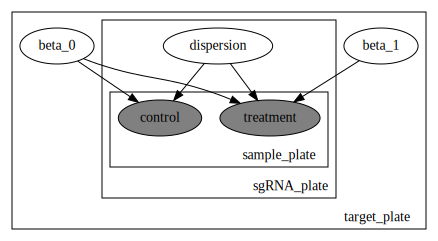

In [10]:
# pyro.enable_validation(False)
pyro.render_model(
    model_mageck3, model_args=(tdata,), render_params=True
)


In [8]:
guide = AutoNormal(model_mageck3, init_scale=0.01)

pyro.clear_param_store()
initial_lr = 0.05
gamma = 0.1  # final learning rate will be gamma * initial_lr
num_steps = 2000
lrd = gamma ** (1 / num_steps)
svi = pyro.infer.SVI(
    model=model_mageck3,
    # guide = baseline_guide,
    guide=guide,
    optim=pyro.optim.ClippedAdam({"lr": initial_lr, "lrd": lrd}),
    # optim=pyro.optim.ClippedAdam({"lr": initial_lr}),
    loss=pyro.infer.Trace_ELBO(max_plate_nesting=3),
)


beta1s, beta1_vars, beta0s, beta0_vars, dm, dv, api, bpi, pis, losses = (
    [] for _ in range(10)
)

for t in range(num_steps):
    losses.append(svi.step(tdata))
    if t == 1:
        print(pyro.get_param_store())
    beta1s.append(pyro.param("AutoNormal.locs.beta_1").clone())
    beta1_vars.append(pyro.param("AutoNormal.scales.beta_1"))
    beta0s.append(pyro.param("AutoNormal.locs.beta_0").clone())
    beta0_vars.append(pyro.param("AutoNormal.scales.beta_0"))
    dm.append(pyro.param("AutoNormal.locs.dispersion").clone())
    dv.append(pyro.param("AutoNormal.scales.dispersion"))
    api.append(pyro.param("alpha_pi").clone().detach())
    bpi.append(pyro.param("beta_pi").clone().detach())
    a = pyro.param("alpha_pi").clone().detach()
    b = pyro.param("beta_pi").clone().detach()
    pis.append(a / (a + b))


In [9]:
a = pyro.param("alpha_pi").clone().detach()
b = pyro.param("beta_pi").clone().detach()
pi = a / (a + b)


In [42]:
n_reps = 4


In [43]:
mix_prob = (
    torch.stack([1.0 - pi, pi])
    .unsqueeze(1)
    .expand(2, n_reps, -1, -1)
    .permute(1, 2, 3, 0)
)


In [44]:
mix_prob.shape


torch.Size([4, 5, 694, 2])

In [10]:
a


tensor([[11.3328, 13.9080, 10.9619,  ..., 12.0898, 11.7109, 14.4110],
        [13.4222, 11.8566, 11.5721,  ..., 11.9835, 11.3643, 12.0474],
        [11.3237, 11.6171, 10.2124,  ..., 10.8511, 14.2129, 12.5899],
        [12.2501, 12.1575, 12.8142,  ..., 10.8937, 12.5061, 12.3835],
        [11.4854, 13.0404, 11.9545,  ..., 13.0547, 12.2343, 10.8535]],
       dtype=torch.float64)

In [46]:
b


tensor([[ 2.7040,  3.1831,  3.0273,  ...,  3.4373,  2.9889,  2.8505],
        [ 3.1478,  8.6339, 42.0481,  ...,  2.8638,  4.4408,  3.4113],
        [ 3.3164,  3.1458, 39.0791,  ...,  2.7117,  2.7544,  3.1913],
        [ 2.7158,  3.0111,  2.9757,  ...,  3.6235,  2.8437,  3.0964],
        [ 3.0693,  2.8971,  2.5317,  ...,  2.7161,  4.1177,  2.8203]],
       dtype=torch.float64)

In [47]:
for k, v in pyro.get_param_store().items():
    print(k)


alpha_pi
beta_pi
AutoNormal.locs.beta_1
AutoNormal.scales.beta_1
AutoNormal.locs.beta_0
AutoNormal.scales.beta_0
AutoNormal.locs.dispersion
AutoNormal.scales.dispersion
AutoNormal.locs.pi
AutoNormal.scales.pi


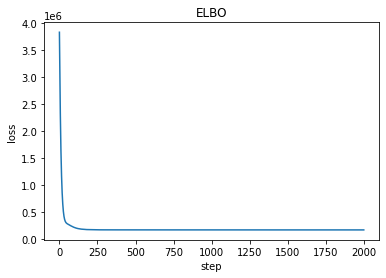

In [48]:
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")


In [49]:
ldlr_idx = np.where(target_info.target.map(lambda s: "LDLR" in s))[0]


In [50]:
negctrl_idx = np.where(target_info.Group == "NegCtrl")[0]


In [51]:
pis[0].shape


torch.Size([5, 694])

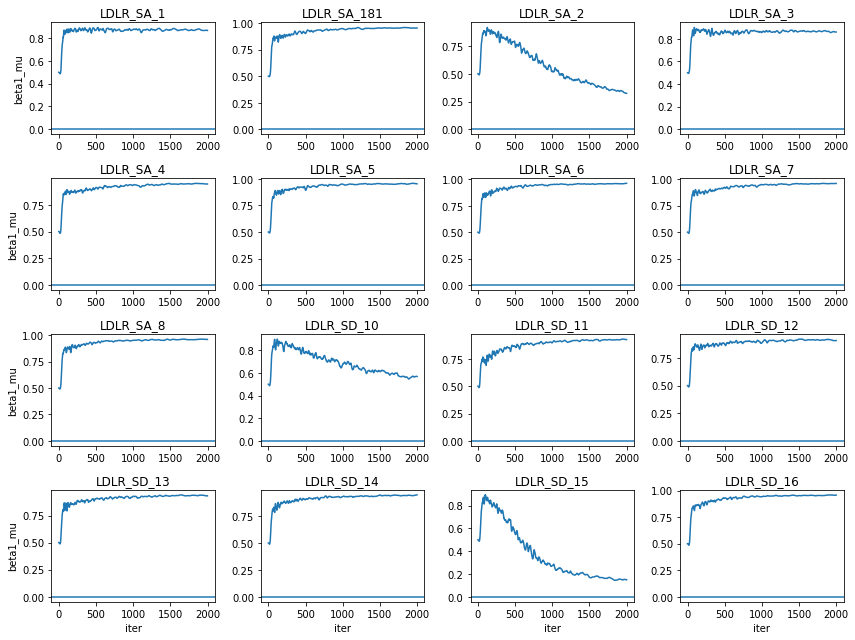

In [52]:
fig, ax = plt.subplots(4, 4, figsize=(12, 9))
for i in range(4):
    for j in range(4):
        ax[i, j].plot(list(map(lambda x: x[0, ldlr_idx[i * 4 + j]], pis)))
        if i == 3:
            ax[i, j].set_xlabel("iter")
        if j == 0:
            ax[i, j].set_ylabel("beta1_mu")
        ax[i, j].set_title(target_info.iloc[ldlr_idx[i * 4 + j], :].target)
        ax[i, j].axhline(y=0)
plt.tight_layout()


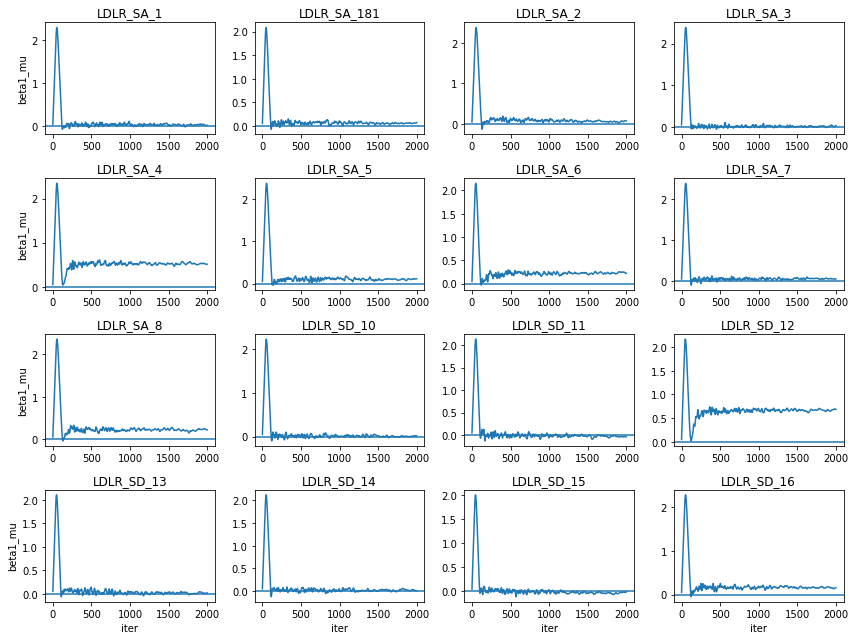

In [53]:
fig, ax = plt.subplots(4, 4, figsize=(12, 9))
for i in range(4):
    for j in range(4):
        ax[i, j].plot(list(map(lambda x: x[ldlr_idx[i * 4 + j]], beta1s)))
        if i == 3:
            ax[i, j].set_xlabel("iter")
        if j == 0:
            ax[i, j].set_ylabel("beta1_mu")
        ax[i, j].set_title(target_info.iloc[ldlr_idx[i * 4 + j], :].target)
        ax[i, j].axhline(y=0)
plt.tight_layout()


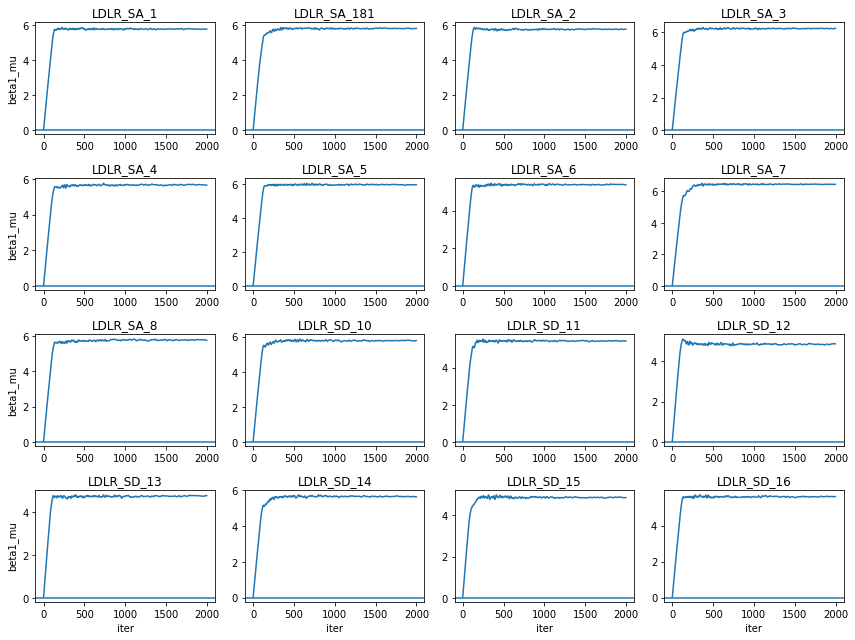

In [54]:
fig, ax = plt.subplots(4, 4, figsize=(12, 9))
for i in range(4):
    for j in range(4):
        ax[i, j].plot(list(map(lambda x: x[ldlr_idx[i * 4 + j]], beta0s)))
        if i == 3:
            ax[i, j].set_xlabel("iter")
        if j == 0:
            ax[i, j].set_ylabel("beta1_mu")
        ax[i, j].set_title(target_info.iloc[ldlr_idx[i * 4 + j], :].target)
        ax[i, j].axhline(y=0)
plt.tight_layout()


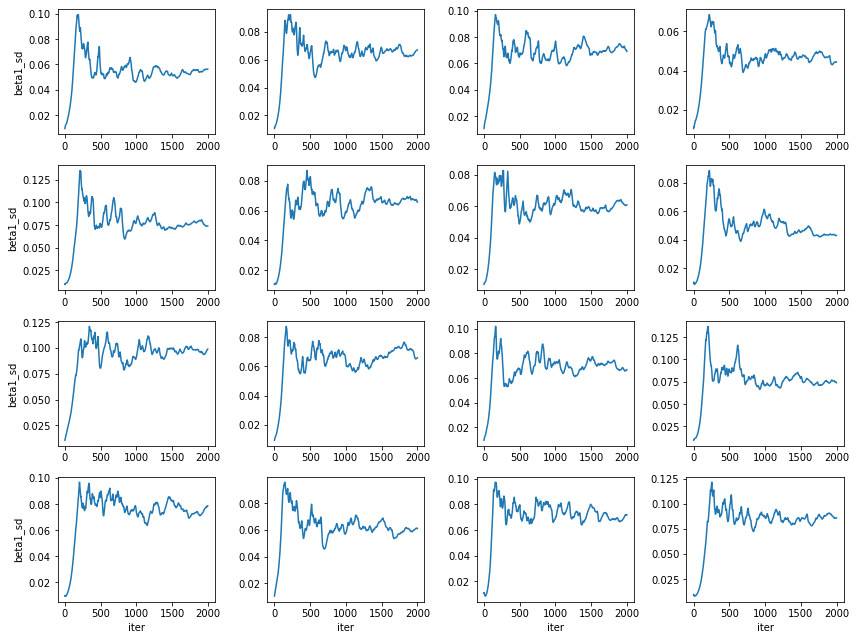

In [55]:
fig, ax = plt.subplots(4, 4, figsize=(12, 9))
for i in range(4):
    for j in range(4):
        ax[i, j].plot(list(map(lambda x: x[ldlr_idx[i * 4 + j]], beta1_vars)))
        if i == 3:
            ax[i, j].set_xlabel("iter")
        if j == 0:
            ax[i, j].set_ylabel("beta1_sd")
plt.tight_layout()


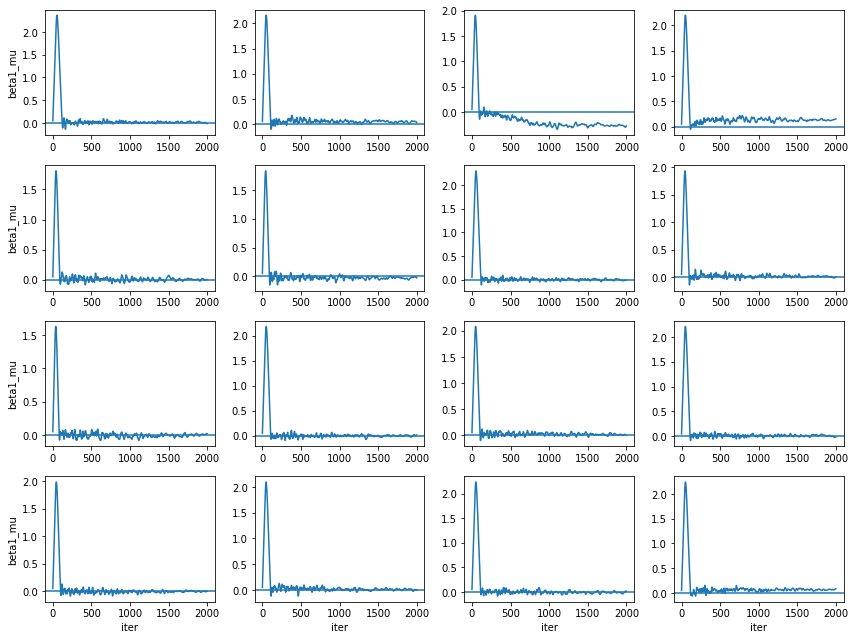

In [56]:
fig, ax = plt.subplots(4, 4, figsize=(12, 9))
for i in range(4):
    for j in range(4):
        ax[i, j].plot(list(map(lambda x: x[negctrl_idx[i * 4 + j]], beta1s)))
        if i == 3:
            ax[i, j].set_xlabel("iter")
        if j == 0:
            ax[i, j].set_ylabel("beta1_mu")
        ax[i, j].axhline(y=0)
plt.tight_layout()


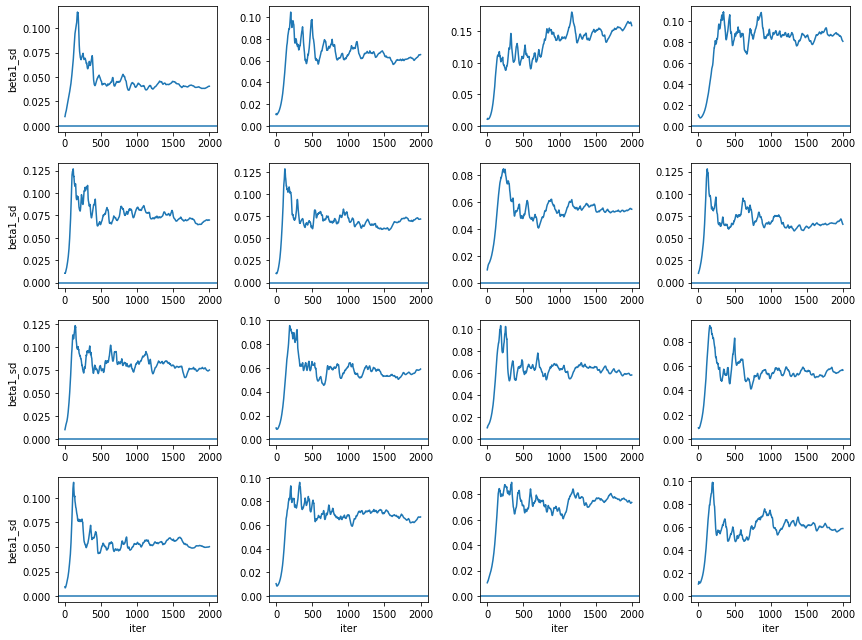

In [57]:
fig, ax = plt.subplots(4, 4, figsize=(12, 9))
for i in range(4):
    for j in range(4):
        ax[i, j].plot(list(map(lambda x: x[negctrl_idx[i * 4 + j]], beta1_vars)))
        if i == 3:
            ax[i, j].set_xlabel("iter")
        if j == 0:
            ax[i, j].set_ylabel("beta1_sd")
        ax[i, j].axhline(y=0)
plt.tight_layout()


In [58]:
import pickle as pkl

# losses.append(svi.step(tdata))
# beta1s.append(pyro.param("beta1_mu").clone())
# beta1_vars.append(pyro.param("beta1_sd"))
# beta0s.append(pyro.param("beta0_mu").clone())
# beta0_vars.append(pyro.param("beta0_sd"))
# #     dm.append(pyro.param('dispersion_mean').clone())
# #     dv.append(pyro.param('dispersion_var').clone())
# api.append(pyro.param("alpha_pi"))
# bpi.append(pyro.param("beta_pi"))

param_hist_dict = {
    "loss": losses,
    "beta1_mu": beta1s,
    "beta1_sd": beta1_vars,
    "beta0_mu": beta0s,
    "beta0_sd": beta0_vars,
    #     "dispersion_mean": dm,
    #     "dispersion_var": dv,
    "alpha_pi": api,
    "beta_pi": bpi,
}
f = open("param_hist_dict_3.pkl", "wb")
pkl.dump(param_hist_dict, f)


In [59]:
f.close()


## Comparing edit rate

In [99]:
edit_rate_data = tdata.edit_rate


In [96]:
edit_rate_fitted = pis[-1]
edit_rate_fitted.shape


torch.Size([5, 694])

Text(0, 0.5, 'fitted edit rate')

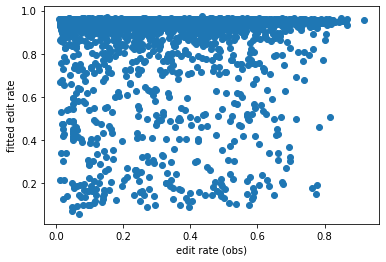

In [101]:
plt.scatter(edit_rate_data, edit_rate_fitted)
plt.xlabel("edit rate (obs)")
plt.ylabel("fitted edit rate")


In [104]:
np.corrcoef(edit_rate_data.flatten(), edit_rate_fitted.flatten())


array([[1.        , 0.02622198],
       [0.02622198, 1.        ]])

## Comparison with MAGeCK results

In [60]:
target_info = target_info.loc[target_info.Group != 0, :].reset_index(drop=True)


In [61]:
target_info = target_info[["target", "Group"]]


In [62]:
target_info


,target,Group
0,CONTROL_1,NegCtrl
1,CONTROL_10,NegCtrl
2,CONTROL_11,NegCtrl
3,CONTROL_12,NegCtrl
4,CONTROL_13,NegCtrl
...,...,...
689,rs9884390_Maj_ABE_345,Variant
690,rs9894946_Maj_ABE_346,Variant
691,rs9941087_Min_ABE_582,Variant
692,rs9982111_Min_ABE_583,Variant


In [63]:
import pandas as pd

tbl = pd.read_csv(
    "../../data/07+1021_ANBE_data/guide_counts_lenient/mageck_results/bot_vs_top/mle_guide/LDLvar_guide.gene_summary.txt",
    sep="\t",
)


In [64]:
import pandas as pd

tbl_obs = pd.read_csv(
    "../../data/07+1021_ANBE_data/guide_counts_lenient/mageck_results/bot_vs_top/mle_guide_obs/LDLvar_guide.gene_summary.txt",
    sep="\t",
)


In [65]:
tbl.Gene.to_list() == adata.obs[["target"]].drop_duplicates().target.to_list()


True

In [66]:
beta1_mu = beta1s[-1].detach().numpy()
beta1_var = beta1_vars[-1].detach().numpy()
z_score = beta1_mu / beta1_var


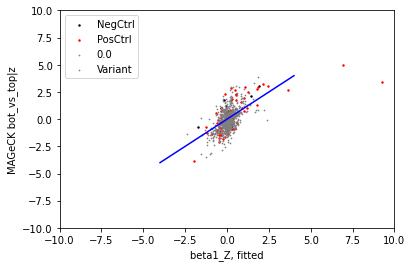

In [67]:
cmap = {"NegCtrl": "black", "PosCtrl": "red", "Variant": "grey", 0.0: "grey"}
smap = {"NegCtrl": 2, "PosCtrl": 2, "Variant": 0.5, 0.0: 0.5}
for g in adata.obs.Group.unique():
    gidx = np.where(target_info.Group == g)[0]

    plt.scatter(z_score[gidx], tbl["bot_vs_top|z"][gidx], label=g, c=cmap[g], s=smap[g])
    plt.xlim((-10, 10))
    plt.ylim((-10, 10))
    plt.xlabel("beta1_Z, fitted")
    plt.ylabel("MAGeCK bot_vs_top|z")
plt.legend()
xpt = np.linspace(-4, 4, 100)
plt.plot(xpt, xpt, "b")


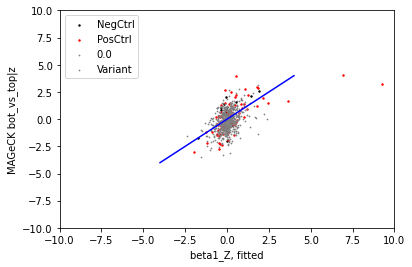

In [68]:
cmap = {"NegCtrl": "black", "PosCtrl": "red", "Variant": "grey", 0.0: "grey"}
smap = {"NegCtrl": 2, "PosCtrl": 2, "Variant": 0.5, 0.0: 0.5}
for g in adata.obs.Group.unique():
    gidx = np.where(target_info.Group == g)[0]

    plt.scatter(
        z_score[gidx], tbl_obs["bot_vs_top|z"][gidx], label=g, c=cmap[g], s=smap[g]
    )
    plt.xlim((-10, 10))
    plt.ylim((-10, 10))
    plt.xlabel("beta1_Z, fitted")
    plt.ylabel("MAGeCK bot_vs_top|z")
plt.legend()
xpt = np.linspace(-4, 4, 100)
plt.plot(xpt, xpt, "b")


In [69]:
np.corrcoef(z_score, tbl["bot_vs_top|z"])


array([[1.        , 0.58012567],
       [0.58012567, 1.        ]])

In [70]:
np.corrcoef(z_score, tbl_obs["bot_vs_top|z"])


array([[1.        , 0.47042359],
       [0.47042359, 1.        ]])

In [71]:
for k, v in pyro.get_param_store().items():
    print(k, v.shape)


alpha_pi torch.Size([5, 694])
beta_pi torch.Size([5, 694])
AutoNormal.locs.beta_1 torch.Size([694])
AutoNormal.scales.beta_1 torch.Size([694])
AutoNormal.locs.beta_0 torch.Size([694])
AutoNormal.scales.beta_0 torch.Size([694])
AutoNormal.locs.dispersion torch.Size([5, 694])
AutoNormal.scales.dispersion torch.Size([5, 694])
AutoNormal.locs.pi torch.Size([5, 694])
AutoNormal.scales.pi torch.Size([5, 694])


In [72]:
pyro.get_param_store().save("mageck_params_binom_pi.psd")


In [73]:
np.corrcoef(beta1s[-1].detach().numpy(), tbl_obs["bot_vs_top|beta"])


array([[1.        , 0.40667078],
       [0.40667078, 1.        ]])

## Pos/NegCtrls

In [74]:
def classify_targets(row):
    if row.Group == "PosCtrl":
        target_name = row.target
        if "LDLR" in target_name or "SREBF2" in target_name or "HNF4A" in target_name:
            return "PosCtrl_dec"
        elif "MYLIP" in target_name or "ACAT2" in target_name or "LSS" in target_name:
            return "PosCtrl_inc"
        else:
            print(row)
            raise ValueError(row)
    return row.Group


In [75]:
target_info["Group2"] = ""
for i in range(len(target_info)):
    target_info.Group2[i] = classify_targets(target_info.iloc[i, :])


In [76]:
sum(target_info.Group == "NegCtrl")


20

In [77]:
target_info[target_info.Group != target_info.Group2]


,target,Group,Group2
20,ACAT2_SA_44,PosCtrl,PosCtrl_inc
21,ACAT2_SA_45,PosCtrl,PosCtrl_inc
22,ACAT2_SA_46,PosCtrl,PosCtrl_inc
23,ACAT2_SA_47,PosCtrl,PosCtrl_inc
24,ACAT2_SA_48,PosCtrl,PosCtrl_inc
...,...,...,...
106,SREBF2_SD_67,PosCtrl,PosCtrl_dec
107,SREBF2_SD_68,PosCtrl,PosCtrl_dec
108,SREBF2_SD_69,PosCtrl,PosCtrl_dec
109,SREBF2_SD_70,PosCtrl,PosCtrl_dec


In [79]:
z_score.shape


(694,)

Beta is positive when enriched in the bottom bin. So here, bottom bin should be decreased.

In [80]:
pos_idx = np.where(target_info.Group2 == "PosCtrl_dec")[0]
neg_idx = np.where(target_info.Group2 == "PosCtrl_inc")[0]
var_idx = np.where(target_info.Group2 == "Variant")[0]
ctrl_idx = np.where(target_info.Group2 == "NegCtrl")[0]


def sensitivity(z, pos_inc_idx, pos_dec_idx, pos_thres=3):
    TP = sum(z[pos_inc_idx] >= pos_thres) + sum(z[pos_dec_idx] <= -pos_thres)
    return TP / (len(pos_inc_idx) + len(pos_dec_idx))


def specificity(z, neg_ctrl_idx, pos_thres=3):
    # 1 - FalsePositives / (FalsePositives + TrueNegatives) = TN / (FP + TN)
    return sum(np.abs(z[neg_ctrl_idx]) < pos_thres) / len(neg_ctrl_idx)


def plot_auc(z, pos_inc_idx, pos_dec_idx, neg_ctrl_idx):
    thres = np.linspace(min(abs(z)), max(z), 100)
    sens = []
    spec = []
    for t in thres:
        sens.append(sensitivity(z, pos_inc_idx, pos_dec_idx, t))
        spec.append(1 - specificity(z, neg_ctrl_idx, t))
    plt.scatter(spec, sens)
    plt.xlabel("1 - specificity")
    plt.ylabel("sensitivity")

    diag_x = np.linspace(0, 1, 100)
    plt.plot(diag_x, diag_x)


def precision(z, pos_inc_idx, pos_dec_idx, neg_ctrl_idx, pos_thres=3):
    # Precision = TruePositives / (TruePositives + FalsePositives)
    TP = sum(z[pos_inc_idx] >= pos_thres) + sum(z[pos_dec_idx] <= -pos_thres)
    FP = sum(np.abs(z[neg_ctrl_idx]) >= pos_thres)
    return TP / (TP + FP)


def plot_prc(z, pos_inc_idx, pos_dec_idx, neg_ctrl_idx):
    thres = np.linspace(min(abs(z)), max(z) + 0.1, 100)
    prec = []
    recall = []
    for t in thres:
        recall.append(sensitivity(z, pos_inc_idx, pos_dec_idx, t))
        prec.append(precision(z, pos_inc_idx, pos_dec_idx, neg_ctrl_idx, t))
    plt.scatter(recall, prec)
    plt.xlabel("recall")
    plt.ylabel("precision")


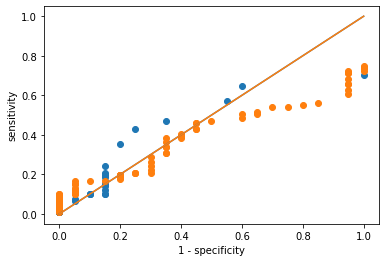

In [92]:
plot_auc(z_score, pos_idx, neg_idx, ctrl_idx)
plot_auc(tbl_obs["bot_vs_top|z"], pos_idx, neg_idx, ctrl_idx)


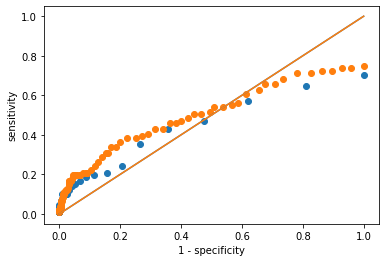

In [91]:
plot_auc(z_score, pos_idx, neg_idx, var_idx)
plot_auc(tbl_obs["bot_vs_top|z"], pos_idx, neg_idx, var_idx)


<ipython-input-80-e4839b5c5f27>:31: RuntimeWarning: invalid value encountered in long_scalars
  return(TP / (TP + FP))


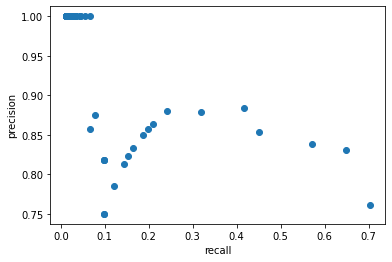

In [85]:
plot_prc(z_score, pos_idx, neg_idx, ctrl_idx)


In [86]:
plot_prc(tbl_obs["bot_vs_top|z"], pos_idx, neg_idx, ctrl_idx)


ZeroDivisionError: division by zero

In [89]:
sensitivity(z_score, pos_idx, neg_idx, 1)


0.16483516483516483

In [90]:
specificity(z_score, ctrl_idx, 1)


0.85